## Prototyping CNN Models
This is the process of trying different CNN model architectures and trying to tune the hyperparameters to achieve the final model code.

**NOTE:** Depending on your GPU and video memory size, you may not be able to reproduce these results by just running all these models in one go. You may have to clear the kernel and gpu memory everytime you run a different model or you may get an error or the model with run without gradients being calculated if memory is maxed out. This seems to be an issue with juypter, but I have not tried it on any other platforms such as Google Colab, etc.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as tf

from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

In [4]:
# see our classes
classes = os.listdir(path="data/train/")
print(classes)

['English', 'French', 'German', 'Italian', 'Spanish']


In [5]:
# import our data set and convert to tensors
transformations = tf.Compose([tf.Resize([64,64]), tf.ToTensor()]) # our transformations when importing the images

trainset = ImageFolder('data/train', transform=transformations)
testset = ImageFolder('data/test', transform=transformations)

In [6]:
img, label = trainset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.6157, 0.5216, 0.4902,  ..., 0.6235, 0.5529, 0.3882],
         [0.8118, 0.6980, 0.6588,  ..., 0.7647, 0.7373, 0.5569],
         [0.8941, 0.7569, 0.6863,  ..., 0.7804, 0.7608, 0.5569],
         ...,
         [0.9882, 0.9647, 0.9647,  ..., 0.9804, 0.9843, 0.9843],
         [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9922, 0.9882, 0.9922]],

        [[0.1843, 0.1529, 0.1373,  ..., 0.1843, 0.1647, 0.1020],
         [0.2706, 0.2118, 0.1961,  ..., 0.2353, 0.2275, 0.1647],
         [0.3294, 0.2353, 0.2039,  ..., 0.2392, 0.2353, 0.1647],
         ...,
         [0.6745, 0.5373, 0.5020,  ..., 0.5176, 0.5333, 0.5373],
         [0.8902, 0.8039, 0.7765,  ..., 0.5490, 0.5490, 0.6118],
         [0.9490, 0.9255, 0.9059,  ..., 0.8196, 0.8431, 0.8471]],

        [[0.4941, 0.5020, 0.5020,  ..., 0.4941, 0.5020, 0.4941],
         [0.4275, 0.4706, 0.4863,  ..., 0.4510, 0.4588, 0.4902],
         [0.3961, 0.4588, 0.4824,  ..., 0.4510, 0.4549, 0.

In [7]:
print(testset.classes)
print(trainset.classes)

['English', 'French', 'German', 'Italian', 'Spanish']
['English', 'French', 'German', 'Italian', 'Spanish']


### check image files, delete this part after if necessary

In [8]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  English (0)


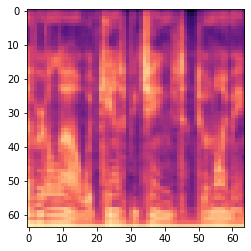

In [9]:
show_example(*trainset[0])

Label:  English (0)


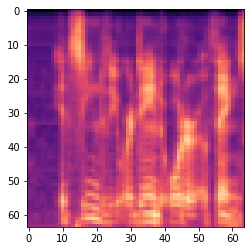

In [10]:
show_example(*testset[0])

_______________________________________________________________________________

## Training, Validation Sets

In [11]:
random_seed = 10
torch.manual_seed(random_seed);

In [12]:
# train - validation split with validation being 20% of training data
val_size = int(len(trainset)*0.20)
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(31500, 7875)

In [13]:
# set our batch size and intialize our data loader to feed batches into the model
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

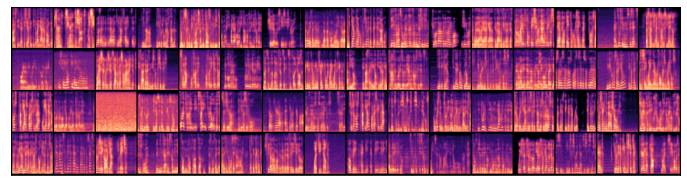

In [15]:
show_batch(train_dl)

## Models

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
# helper functions to use GPU
def get_device():
    '''Pick GPU, otherwise CPU if not avail'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to the chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# using oop to set up a wrapper class for our dataloaders to use gpu
class DeviceDataLoader():
    '''Wraps a dataloader to move data into a device'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        '''Yields a batch of data after moving to device'''
        for i in self.dl:
            yield to_device(i, self.device)
    
    def __len__(self):
        '''Number of batches'''
        return len(self.dl)

# plot accuracies
def plot_accuracy(train_accuracy, val_accuracy):
    plt.figure(figsize=(7,5))
    plt.plot(train_accuracy, '-x')
    plt.plot(val_accuracy, '-o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracy vs Epochs')
    plt.show()
    
# plot losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['training', 'validation'])
    plt.title('Loss vs Epochs')
    plt.show()

In [18]:
## define some helper functions to evaluate (get accuracy and loss) and fit the model

def evaluate(model, dataloader, calc_loss=False, opt=None, grad_clip=None):
    '''
    Helper function to get accuracy and loss(optional) even do a step with the optimizer if present
    We can use this function in multiple ways depending on the parameters: just calculate accuracy and/or loss and/or gradients + update weights
    This way, we can utilize this function for both validation and train dataloaders for each epoch
    
    Inputs
    model = the model 
    dataloader = validation or train or test dataloader
    calc_loss = set to True if you wish to calculate loss, else by default just returns empty list
    opt = set an optimizer function to calculate gradients and update weights, else None by default
    grad_clip = if not None, use gradient clipping, else default is None and it won't use gradient clipping. Controls for exploding / vanishing gradients.
    '''
    
    correct = 0
    total = 0
    losses = []
    
    if opt is not None:
        
        # calculate gradients and use optimizer
        for batch in dataloader:
            
            # forward pass through the model
            inputs, labels = batch
            outputs = model(inputs)
            
            # calculate loss if parameter set to True
            if (calc_loss==True):            
                loss = model.loss(outputs, labels)   # Calculate loss
                losses.append(loss.item())
            
            # compute gradients
            loss.backward()
            # update params
            opt.step()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # reset gradients
            opt.zero_grad()
                               
            # Get the prediction of the net on the images
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)

            # Count those we got correct
            correct += torch.sum(predicted==labels).item()
                       
        # calculate total correct cases
        accuracy = 100 * correct / total
        avg_loss = np.mean(losses)
    
    else:
    
        # no gradients calculated
        with torch.no_grad():
            for batch in dataloader:

                # forward pass through the model
                inputs, labels = batch
                outputs = model(inputs)

                # calculate loss if parameter set to True
                if (calc_loss==True):            
                    loss = model.loss(outputs, labels)   # Calculate loss
                    losses.append(loss.item())

                # Get the prediction of the net on the images
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)

                # Count those we got correct
                correct += torch.sum(predicted==labels).item()

            # calculate total correct cases
            accuracy = 100 * correct / total
            avg_loss = np.mean(losses)
        
    return avg_loss, accuracy

def fit(epochs, model, train_loader, val_loader, grad_clip=False):
    ''' Function where we fit the model and record the metrics for each epoch with the inputted hyperparameters'''
    
    # Instantiate our model and empty lists to record metrics
    model.cuda() # move model to GPU'
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # train and validate for each epoch
    for epoch in range(epochs):

        ## Training Phase ##
        model.train()
        # run the evaluate function with optimizer to get train loss and accuracy
        train_loss, train_accuracy = evaluate(model, train_loader, calc_loss=True, opt=model.optimizer, grad_clip=grad_clip)
        
        # record training metrics
        train_losses.append(np.mean(train_loss))
        train_accuracies.append(np.mean(train_accuracy))
   
        ## Validation phase ##
        model.eval()
        # run the evaluate function on validation dataloader to get average loss and accuracy
        val_loss, val_accuracy = evaluate(model, val_loader, calc_loss=True) 
        
        # record validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # print the metrics
        print(f"Epoch: {epoch+1} / {epochs} | "\
            f"Avg Train Loss: {np.round(train_loss, 4)} | "\
            f"Train accuracy: {np.round(train_accuracy, 2)} | "\
            f"Avg Validation Loss: {np.round(val_loss, 4)} | "\
            f"Validation Accuracy: {np.round(val_accuracy, 2)}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [19]:
# set up our dataloader and devices for GPU computing
device = get_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

device

device(type='cuda')

#### First Model
let's try our first model

In [54]:
# First Simple Model
class CNN_model_1(nn.Module):
    def __init__(self, opt_fun, lr, **opt_params):
        '''
        opt_fun = optimizer function (eg: torch.optim.SGD)
        lr = learning rate
        **opt_params = extra optional parameters for optimizer function (eg: weight_decay, momentum, etc...)
        '''
        super(CNN_model_1, self).__init__()

        self.net = nn.Sequential(
            
            # convolution layers with max pooling 
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # our layer's input & output size, kernals, strides, padding 
            nn.ReLU(),                                             # activation function
            nn.MaxPool2d(2,2),                                     # max pooling: output 32x32x32

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),          
            nn.MaxPool2d(2,2),                                     # output 32x16x16

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),             
            nn.MaxPool2d(2,2),                                     # output 32x8x8

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),            
            nn.MaxPool2d(2,2),                                     # output 32x4x4

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),            
            nn.MaxPool2d(2,2),                                     # output 32x2x2

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        
            nn.ReLU(),           
            nn.MaxPool2d(2,2),                                     # output 32x1x1
            
            # flatten and pass through a dense layer
            nn.Flatten(),                                          # flattens to a vector 
            nn.Linear(32, 5)                                       # output of 4 for each one of our classes
        )
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, **opt_params)
    
    def forward(self, x):
        """Perform a forward pass and return the outputs"""
        return self.net(x)  # pass through the network

In [93]:
# initialize our model
model_1 = CNN_model_1(opt_fun=torch.optim.Adam, lr=0.001)
model_1.cuda()

CNN_model_1(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): R

In [77]:
# quick check to see if evaluate and see if model is untrained and working
evaluate(model_1, dataloader=val_dl, calc_loss=True)

In [94]:
# training and validating our model
history = fit(epochs=20, model=model_1, train_loader=train_dl, val_loader=val_dl) 

Epoch: 1 / 20 | Avg Train Loss: 1.409 | Train accuracy: 36.91 | Avg Validation Loss: 1.2379 | Validation Accuracy: 47.7
Epoch: 2 / 20 | Avg Train Loss: 1.1667 | Train accuracy: 52.64 | Avg Validation Loss: 1.1712 | Validation Accuracy: 51.44
Epoch: 3 / 20 | Avg Train Loss: 1.0238 | Train accuracy: 59.78 | Avg Validation Loss: 0.9699 | Validation Accuracy: 61.46
Epoch: 4 / 20 | Avg Train Loss: 0.9247 | Train accuracy: 64.39 | Avg Validation Loss: 0.9131 | Validation Accuracy: 64.94
Epoch: 5 / 20 | Avg Train Loss: 0.8474 | Train accuracy: 67.51 | Avg Validation Loss: 0.8319 | Validation Accuracy: 68.39
Epoch: 6 / 20 | Avg Train Loss: 0.7866 | Train accuracy: 69.97 | Avg Validation Loss: 0.7653 | Validation Accuracy: 70.91
Epoch: 7 / 20 | Avg Train Loss: 0.7257 | Train accuracy: 72.57 | Avg Validation Loss: 0.7422 | Validation Accuracy: 71.75
Epoch: 8 / 20 | Avg Train Loss: 0.6786 | Train accuracy: 74.46 | Avg Validation Loss: 0.7012 | Validation Accuracy: 73.9
Epoch: 9 / 20 | Avg Train L

In [97]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history

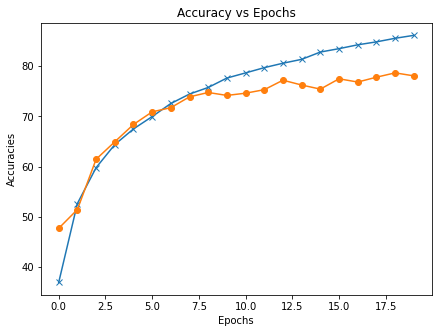

In [98]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

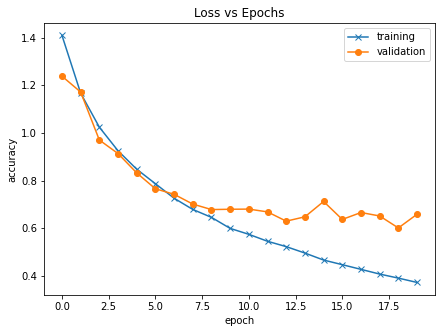

In [101]:
plot_losses(train_losses, val_losses)

In [111]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

test_loss_1, test_score_1 = evaluate(model_1, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score_1:.2f}% | Test Loss: {test_loss_1:.4f}")

Test Score: 72.53% | Test Loss: 0.9239


In [112]:
# save the state model of the trained model
torch.save(model_1.state_dict(), "trained_model_1_state.pt")

## to load:
#new_model_1 = CNN_model_1()
#new_model_1.load_state_dict(torch.load("trained_model_1_state.pt"))
#new_model_1

## Let's Try our Second (More Complex) Model
We have allowed the number of nodes per layer to expand, and we added more layers.

In [18]:
# Second Model
class CNN_model_2(nn.Module):
    def __init__(self, opt_fun, lr, **opt_params):
        '''
        opt_fun = optimizer function (eg: torch.optim.SGD)
        lr = learning rate
        **opt_params = extra optional parameters for optimizer function (eg: weight_decay, momentum, etc...)
        '''
        super(CNN_model_2, self).__init__()

        self.net = nn.Sequential(
            
            # convolution layers
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 4 x 4
            
            # dense layers
            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),  # is 1024*4*4 because of the dimension of the last maxpool
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, **opt_params)
    
    def forward(self, x):
        """Perform a forward pass and return the outputs"""
        return self.net(x)  # pass through the network

In [19]:
# initialize our model
model_2 = CNN_model_2(opt_fun=torch.optim.Adam, lr=0.001)
model_2.cuda()

CNN_model_2(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

In [21]:
# quick check to see if evaluate and see if model is untrained and working
evaluate(model_2, dataloader=val_dl, calc_loss=True)

(1.6094968857303742, 19.86031746031746)

In [51]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

541065216

In [23]:
# training and validating our model
history2 = fit(epochs=20, model=model_2, train_loader=train_dl, val_loader=val_dl)

Epoch: 1 / 20 | Avg Train Loss: 1.4657 | Train accuracy: 32.41 | Avg Validation Loss: 1.3013 | Validation Accuracy: 44.9
Epoch: 2 / 20 | Avg Train Loss: 1.1934 | Train accuracy: 50.33 | Avg Validation Loss: 1.0923 | Validation Accuracy: 56.86
Epoch: 3 / 20 | Avg Train Loss: 0.98 | Train accuracy: 61.69 | Avg Validation Loss: 0.8693 | Validation Accuracy: 66.86
Epoch: 4 / 20 | Avg Train Loss: 0.8207 | Train accuracy: 68.63 | Avg Validation Loss: 0.7597 | Validation Accuracy: 71.38
Epoch: 5 / 20 | Avg Train Loss: 0.6871 | Train accuracy: 73.9 | Avg Validation Loss: 0.6714 | Validation Accuracy: 74.87
Epoch: 6 / 20 | Avg Train Loss: 0.5761 | Train accuracy: 78.47 | Avg Validation Loss: 0.6264 | Validation Accuracy: 76.06
Epoch: 7 / 20 | Avg Train Loss: 0.5023 | Train accuracy: 81.15 | Avg Validation Loss: 0.6136 | Validation Accuracy: 77.36
Epoch: 8 / 20 | Avg Train Loss: 0.4223 | Train accuracy: 84.36 | Avg Validation Loss: 0.5742 | Validation Accuracy: 79.15
Epoch: 9 / 20 | Avg Train Lo

In [24]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history2

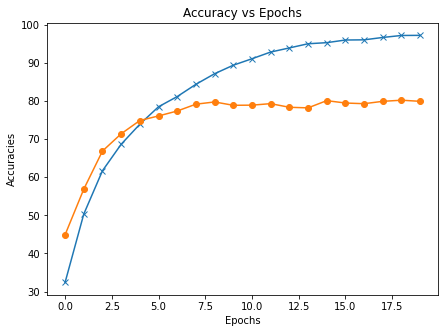

In [25]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

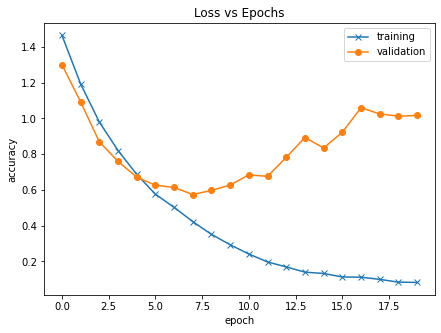

In [26]:
plot_losses(train_losses, val_losses)

In [30]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss_2, test_score_2 = evaluate(model_2, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score_2:.2f}% | Test Loss: {test_loss_2:.4f}")

Test Score: 71.12% | Test Loss: 1.8343


In [28]:
# save the state model of the trained model
torch.save(model_2.state_dict(), "trained_model_2_state.pt")

## to load:
#new_model_2 = CNN_model_2()
#new_model_2.load_state_dict(torch.load("trained_model_2_state.pt"))
#new_model_2

## Let's try with dropout and batch normalization

In [20]:
# Third Model
class CNN_model_3(nn.Module):
    def __init__(self, opt_fun, lr, **opt_params):
        '''
        opt_fun = optimizer function (eg: torch.optim.SGD)
        lr = learning rate
        **opt_params = extra optional parameters for optimizer function (eg: weight_decay, momentum, etc...)
        '''
        super(CNN_model_3, self).__init__()

        self.net = nn.Sequential(
            
           # convolution layers
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),     # adding batch normalization
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32
            nn.Dropout(p=0.25), # adding dropout regularization
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16
            nn.Dropout(p=0.25),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8
            nn.Dropout(p=0.25),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4
            nn.Dropout(p=0.25),
            
            # flatten then go through some dense layers
            nn.Flatten(), 
            nn.Linear(512*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 5))   # output of 5 for each of our class
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = opt_fun(self.parameters(), lr=lr, **opt_params)
    
    def forward(self, x):
        """Perform a forward pass and return the outputs"""
        return self.net(x)  # pass through the network

In [19]:
# initialize our model
model_3 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001)
model_3.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [20]:
# quick check to see if evaluate and see if model is untrained and working
evaluate(model_3, dataloader=val_dl, calc_loss=True)

(1.6864221672857962, 20.152380952380952)

In [3]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

0

In [43]:
# training and validating our model
history3 = fit(epochs=20, model=model_3, train_loader=train_dl, val_loader=val_dl)

Epoch: 1 / 20 | Avg Train Loss: 1.029 | Train accuracy: 59.16 | Avg Validation Loss: 1.1797 | Validation Accuracy: 56.24
Epoch: 2 / 20 | Avg Train Loss: 0.6353 | Train accuracy: 76.2 | Avg Validation Loss: 0.5562 | Validation Accuracy: 79.31
Epoch: 3 / 20 | Avg Train Loss: 0.466 | Train accuracy: 83.07 | Avg Validation Loss: 0.5335 | Validation Accuracy: 80.84
Epoch: 4 / 20 | Avg Train Loss: 0.3602 | Train accuracy: 86.8 | Avg Validation Loss: 0.4378 | Validation Accuracy: 83.78
Epoch: 5 / 20 | Avg Train Loss: 0.288 | Train accuracy: 89.75 | Avg Validation Loss: 0.4178 | Validation Accuracy: 85.55
Epoch: 6 / 20 | Avg Train Loss: 0.2346 | Train accuracy: 91.53 | Avg Validation Loss: 0.3089 | Validation Accuracy: 88.93
Epoch: 7 / 20 | Avg Train Loss: 0.1952 | Train accuracy: 93.13 | Avg Validation Loss: 0.2454 | Validation Accuracy: 91.52
Epoch: 8 / 20 | Avg Train Loss: 0.1656 | Train accuracy: 94.19 | Avg Validation Loss: 0.2908 | Validation Accuracy: 89.98
Epoch: 9 / 20 | Avg Train Los

In [44]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history3

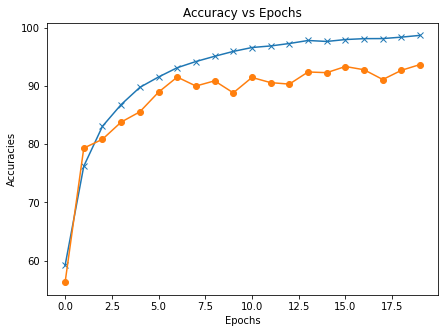

In [45]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

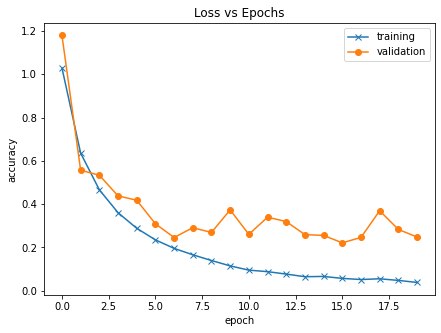

In [46]:
plot_losses(train_losses, val_losses)

In [48]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss_3, test_score_3 = evaluate(model_3, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score_3:.2f}% | Test Loss: {test_loss_3:.4f}")

Test Score: 85.66% | Test Loss: 0.6416


In [49]:
# save the state model of the trained model
torch.save(model_3.state_dict(), "trained_model_3_state.pt")

## to load:
#new_model_3 = CNN_model_3()
#new_model_3.load_state_dict(torch.load("trained_model_3_state.pt"))
#new_model_3

This seems to be the best model out of the three. Let's move onto tuning its hyperparameters now.

## Optimizing Hyperparameters
Seems like model 3 with batch normalization and dropout is the best performing model. Let's now try and tune the hyperparameters. We will adjust the follow parameters:

**Weight decay**: The more complex our model is, the higher chance it will overfit. Weight Decay is a regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. This way, we can penalize complexity and help reduce overfitting. From the train/validation/test results we see that as we run more epochs, the bigger the training accuracy grows, but the validation accuracy stays relatively the same. This is suggesting that there is increasing overfitting. We can also do early stopping (stop the model at an epoch before overfitting happens), but let's see how we perform with weight decay regularization first. Since our model isn't too complex, we can start with lower values: 0.01 and 0.0001. The default value is 0 in torch.optim.Adam.

**Gradient clipping**: This limits the gradients to a specified (usually small) range. This will help to prevent undesirable changes in parameters due to large gradient values. This can help combat both exploding gradients and vanishing gradients, and potentially improve the model's ability to find the true local minimum. We can start with 0.1.

**Learning Rate**: We will try for different values of learning rates. However, from studies I have read, it seems like smaller batches do better with smaller learning rates. Therefore, since our batch size is only 64, we should actually go for a small learning rate. I propose trying both 0.001 and 0.0001.

**Epochs**: We have seen in the previous example that 20 epochs seem to be leveling out. However, there isn't a noticable increase or global min in the loss vs epochs graph. This suggests that we can try a large epoch and then retrain at a more desirable value. We can also set a parameter to stop the model if the loss or accuracy isn't changing by much anymore. We will also be manually stopping the models early if there are signs that the model just isn't training properly.

As for the loss function, optimizer, kernel size, stride, padding ... we will leave those as is, since it does seem to working well with the model we have. There is no need to change the achitecture or the optimizer at this point. 

#### First Version

In [181]:
# trying our first tuned model with wd=0.01 
model_3_opt1 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001, weight_decay=0.01)
model_3_opt1.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [20]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_cached()
torch.cuda.reset_max_memory_allocated()
torch.cuda.memory_reserved()

C:\ProgramData\Anaconda3\envs\pytorch_proj\lib\site-packages\torch\cuda\memory.py:257: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\pytorch_proj\lib\site-packages\torch\cuda\memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


77594624

In [183]:
# training and validating our model with GRADIENT CLIPPING
history_opt1 = fit(epochs=30, model=model_3_opt1, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 30 | Avg Train Loss: 1.1287 | Train accuracy: 55.19 | Avg Validation Loss: 1.2817 | Validation Accuracy: 49.66
Epoch: 2 / 30 | Avg Train Loss: 0.9908 | Train accuracy: 62.11 | Avg Validation Loss: 1.0294 | Validation Accuracy: 59.06
Epoch: 3 / 30 | Avg Train Loss: 0.9788 | Train accuracy: 62.71 | Avg Validation Loss: 2.8254 | Validation Accuracy: 20.36
Epoch: 4 / 30 | Avg Train Loss: 0.9407 | Train accuracy: 64.43 | Avg Validation Loss: 1.4848 | Validation Accuracy: 39.92


KeyboardInterrupt: 

**I manually stopped our model, because it seems like our model is just not fitting. This is because our weight decay value is too high. When the value is too high, the model can no longer fit well enough no matter how long we train for. Seems like we need a much lower weight decay. Let's try 0.0001.**

#### Second Version
Lowering the weight decay

In [22]:
# trying our SECOND tuned model with wd=0.01
model_3_opt2 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.001, weight_decay=0.0001)
model_3_opt2.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [23]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

77594624

In [24]:
# training and validating our model with GRADIENT CLIPPING
history_opt2 = fit(epochs=30, model=model_3_opt2, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 30 | Avg Train Loss: 1.0182 | Train accuracy: 60.03 | Avg Validation Loss: 1.1025 | Validation Accuracy: 57.82
Epoch: 2 / 30 | Avg Train Loss: 0.6383 | Train accuracy: 76.3 | Avg Validation Loss: 0.88 | Validation Accuracy: 69.46
Epoch: 3 / 30 | Avg Train Loss: 0.4805 | Train accuracy: 82.63 | Avg Validation Loss: 0.502 | Validation Accuracy: 81.16
Epoch: 4 / 30 | Avg Train Loss: 0.3885 | Train accuracy: 85.95 | Avg Validation Loss: 0.4308 | Validation Accuracy: 84.43
Epoch: 5 / 30 | Avg Train Loss: 0.3288 | Train accuracy: 88.18 | Avg Validation Loss: 0.4601 | Validation Accuracy: 84.14
Epoch: 6 / 30 | Avg Train Loss: 0.2898 | Train accuracy: 89.47 | Avg Validation Loss: 0.3223 | Validation Accuracy: 88.43
Epoch: 7 / 30 | Avg Train Loss: 0.2628 | Train accuracy: 90.61 | Avg Validation Loss: 0.3803 | Validation Accuracy: 86.12
Epoch: 8 / 30 | Avg Train Loss: 0.2431 | Train accuracy: 91.25 | Avg Validation Loss: 0.2837 | Validation Accuracy: 90.12
Epoch: 9 / 30 | Avg Train Lo

In [25]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history_opt2

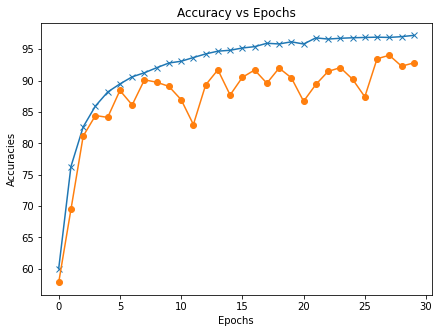

In [26]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

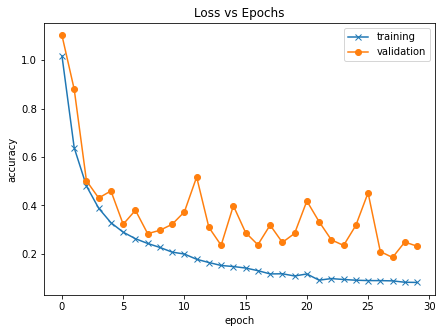

In [27]:
plot_losses(train_losses, val_losses)

In [28]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_3_opt2, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 83.54% | Test Loss: 0.6451


In [29]:
# save the state model of the trained model
torch.save(model_3_opt2.state_dict(), "trained_model_3_opt2_state.pt")

## to load:
#new_model_3 = CNN_model_3()
#new_model_3.load_state_dict(torch.load("trained_model_3_opt2_state.pt"))
#new_model_3

We seem to not have any real changes to our accuracy scores. However, we do see that the training accuracy and validation accuracy are a lot closer, so there is less overfitting. Also, epoch 28 seem to give us the best results so far in all our models.

#### Third Version
So now that we have found a decent weight decay and gradient clipping value, I think we should try to adjust the learning rate to 0.0001 and see what we get. After this, we can use the most optimal model and epoch and retrain our final model on the validation and training set combined.

In [21]:
# trying our SECOND tuned model with wd=0.01
model_3_opt3 = CNN_model_3(opt_fun=torch.optim.Adam, lr=0.0001, weight_decay=0.0001)
model_3_opt3.cuda()

CNN_model_3(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, 

In [22]:
# empty the cache in our GPU before we train another model
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

77594624

In [23]:
# training and validating our model with GRADIENT CLIPPING
history_opt3 = fit(epochs=30, model=model_3_opt3, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)

Epoch: 1 / 30 | Avg Train Loss: 1.0837 | Train accuracy: 56.64 | Avg Validation Loss: 1.0123 | Validation Accuracy: 61.36
Epoch: 2 / 30 | Avg Train Loss: 0.703 | Train accuracy: 73.78 | Avg Validation Loss: 0.7855 | Validation Accuracy: 72.13
Epoch: 3 / 30 | Avg Train Loss: 0.5124 | Train accuracy: 81.43 | Avg Validation Loss: 0.5506 | Validation Accuracy: 79.91
Epoch: 4 / 30 | Avg Train Loss: 0.3959 | Train accuracy: 85.83 | Avg Validation Loss: 0.4352 | Validation Accuracy: 84.13
Epoch: 5 / 30 | Avg Train Loss: 0.304 | Train accuracy: 89.2 | Avg Validation Loss: 0.4539 | Validation Accuracy: 83.9
Epoch: 6 / 30 | Avg Train Loss: 0.2444 | Train accuracy: 91.25 | Avg Validation Loss: 0.3226 | Validation Accuracy: 88.32
Epoch: 7 / 30 | Avg Train Loss: 0.1979 | Train accuracy: 92.98 | Avg Validation Loss: 0.3765 | Validation Accuracy: 87.09
Epoch: 8 / 30 | Avg Train Loss: 0.1652 | Train accuracy: 94.13 | Avg Validation Loss: 0.2341 | Validation Accuracy: 92.01
Epoch: 9 / 30 | Avg Train Lo

In [24]:
# load the metrics into separate variables from our fit
train_losses, train_accuracies, val_losses, val_accuracies = history_opt3

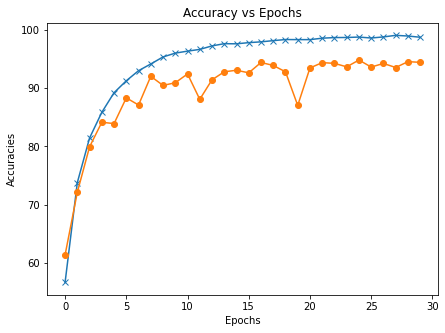

In [25]:
# plot metrics
plot_accuracy(train_accuracies, val_accuracies)

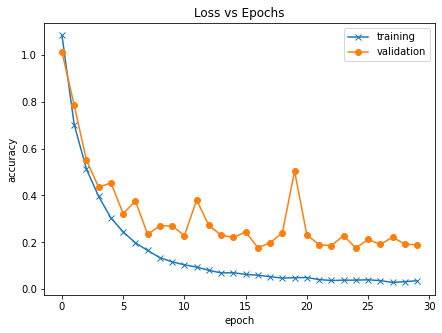

In [26]:
plot_losses(train_losses, val_losses)

In [27]:
# set up our test dataloader
test_dl = DeviceDataLoader(DataLoader(testset, batch_size*2), device)

# calculate test score
test_loss, test_score = evaluate(model_3_opt3, dataloader=test_dl, calc_loss=True)

print(f"Test Score: {test_score:.2f}% | Test Loss: {test_loss:.4f}")

Test Score: 81.90% | Test Loss: 0.8470


In [28]:
# save the state model of the trained model
torch.save(model_3_opt3.state_dict(), "trained_model_3_opt3_state.pt")

## to load:
#new_model_3 = CNN_model_3()
#new_model_3.load_state_dict(torch.load("trained_model_3_opt3_state.pt"))
#new_model_3

#### Results
- Baseline Model 3: ~98% train | ~93% validation | ~85% test
- 1st optimizing attempt: Failed to fit properly, weight decay was too high
- 2nd optimizing attempt: ~97% train | ~92% validation | ~83% test
- 3rd optimizing attempt: ~98% train | ~94% validation | ~81% test

Our test scores seem to be getting lower for each of these models. However our validation set's accuracy are around the same at 92-93%. 

Next, we can perform early stopping for each of these models based on the loss vs epochs graph. We can then train the entire training set on the optimal epoch for each of these models and try scoring it again with the test set. We will then select the model with the best test accuracy. 

**Here are the epochs that we will perform early stopping:**

- Baseline Model - 7th epoch
- Second Optimized Model - 8th epoch
- Third optimized model - 17th epoch

## Baseline Model - Retrain



In [33]:
## Set up the entire trainset dataloader
train_dl = DeviceDataLoader(DataLoader(trainset, batch_size, shuffle=True, num_workers=4), device)

In [ ]:
how to do this?

In [ ]:
#history_baseline = fit(epochs=7, model=model_3_opt3, train_loader=train_dl, val_loader=val_dl, grad_clip=0.1)